
## Print figures of coarsened Himawari cloud mask (distributed)


In [ ]:
import os,sys
from glob import glob
#
import xarray as xr
from dask import compute, delayed
from dask.distributed import Client
# 
from datetime import datetime
#
from utils import *

In [2]:
### get dask handles and check dask server status
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
client.restart()
# upload utils.py to workers
client.upload_file('utils.py')

In [3]:
client

Client Scheduler: tcp://10.148.1.0:8786 Dashboard: http://10.148.1.0:8787,Cluster Workers: 34 Cores: 136 Memory: 340.00 GB


In [4]:
# data path
dpath = '/home/datawork-lops-osi/data/hw/mask/';
figdir = '/home1/datahome/aponte/iwave_sst/hw/figs/'

filenames = sorted(glob(dpath+'*.nc'))
print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
# tmp, subset number of files
#filenames = filenames[:10000] # passes with 1000 if mean on fmask
print('Number of files processed: %d' %len(filenames))


Number of files available: 24534
Number of files processed: 24534


In [5]:
# first test
def process(f):
    # coarsen factor [deg]
    dl = 0.5
    #chunks=()
    # open file
    mask = xr.open_dataset(f)['QA']
    # massage the mask to get cloud flag
    fmask = process_raw_mask(mask)
    # coarsen fields
    #cmask = coarsen(fmask, dl, chunks) # this fills up memory for >= 500 files
    #
    m = float(fmask.mean().values)
    #
    return m


In [8]:
values = [delayed(process)(f) for f in filenames]
results = compute(*values, get=client.get)
#print(results)

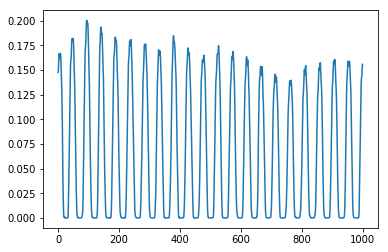

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(results[:1000])
plt.show()

---

# !!! Do not look below !!!

---

In [5]:
# coarsen factor [deg]
dl = 0.5
chunks=()

def nprocess(f):
    return f

def process(f):
    global dl, chunks, figdir
    #
    time = datetime.strptime(f,dpath+'NC_H08_%Y%m%d_%H%M_L2CLPbet_FLDK.02401_02401.nc')
    #
    figname = figdir+'hw_cmask_'+time.strftime('%Y%m%d_%H%M')+'.jpg'
    if not os.path.isfile(figname):
        mask = xr.open_dataset(f)['QA']
        # massage the mask to get cloud flag
        fmask = process_raw_mask(mask)
        # coarsen fields
        cmask = coarsen(fmask, dl, chunks)
        #
        plot_mask(cmask['QA'], colorbar=False, title=str(time), savefig=figname) # crashes with colorbar=True
        #fig.savefig(figname, dpi=300)
        #plt.close(fig)
        #
        mask.close()
        #fmask.close()
        
    return str(time)
    

In [6]:
values = [delayed(process)(f) for f in filenames]
results = compute(*values, get=client.get)
#print(results)

distributed.utils - ERROR - process-bc77ccee-4dc8-4c44-97be-007013d07517
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/client.py", line 1257, in _gather
    st = self.futures[key]
KeyError: 'process-bc77ccee-4dc8-4c44-97be-007013d07517'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 232, in f
    result[0] = yield make_coro()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3

KeyboardInterrupt: 

In [ ]:
# make movie
lpath = os.getcwd()
#print('ffmpeg -y -r 2 -i  '+lpath+figdir+'/hw_cmask%04d.jpg  hw_cmask.mp4')
#print('ffmpeg -y -r 2 -i  '+lpath+figdir+'/hw_cmask*.jpg  hw_cmask.mp4')
# ffmpeg -y -r 2 -i  hw_cmask*.jpg  hw_cmask.mp4
# find . -name "hw_cmask*.jpg" -exec ffmpeg -i {} \;
# ls hw_cmask*.jpg > file.list ; ffmpeg -y -r 2 -i file.list hw_cmask.mp4; rm file.list
# ffmpeg -framerate 10 -pattern_type glob -i '*.jpg' -c:v libx264 -pix_fmt yuv420p out.mp4

In [66]:
client.restart()


Client Scheduler: tcp://10.148.1.0:8786 Dashboard: http://10.148.1.0:8787,Cluster Workers: 34 Cores: 136 Memory: 340.00 GB


In [71]:
client.close()